In [1]:
import numpy as np
import pandas as pd
from scipy import stats,spatial,sparse
from sklearn import manifold,datasets
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
from numba.core.errors import NumbaDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
import phate
X, labels = phate.tree.gen_dla(n_branch=5, branch_length=500, n_dim=10, sigma=1,seed=42)
# X_dists = spatial.distance.squareform(spatial.distance.pdist(X,metric = 'euclidean'))

In [4]:
from dtne import *

In [5]:
def correlation(matrix_A, matrix_B):
    
    from scipy import stats
    n_samples = matrix_A.shape[0]
    pearsonr_correlation_list = []
    spearmanr_correlation_list = []
    for i in range(n_samples):
        pearsonr_res = stats.pearsonr(matrix_A[i], matrix_B[i])
        pearsonr_correlation_list.append(pearsonr_res.statistic) 
        spearmanr_res = stats.spearmanr(matrix_A[i], matrix_B[i])
        spearmanr_correlation_list.append(spearmanr_res.statistic)
        
    pearsonr_correlation_mean = np.mean(pearsonr_correlation_list)
    spearmanr_correlation_mean = np.mean(spearmanr_correlation_list)
    pearsonr_correlation_interval = stats.norm.interval(confidence=0.95, loc=pearsonr_correlation_mean, scale=stats.sem(pearsonr_correlation_list))
    spearmanr_correlation_interval = stats.norm.interval(confidence=0.95, loc=spearmanr_correlation_mean, scale=stats.sem(spearmanr_correlation_list))
    
    correlation_mean = [pearsonr_correlation_mean,spearmanr_correlation_mean]
    correlation_interval = [pearsonr_correlation_interval,spearmanr_correlation_interval]
    
    pearsonr_correlation = [pearsonr_correlation_mean,pearsonr_correlation_interval]
    spearmanr_correlation = [spearmanr_correlation_mean,spearmanr_correlation_interval]
    
    return pearsonr_correlation_list,spearmanr_correlation_list,pearsonr_correlation,spearmanr_correlation 

In [6]:
import phate
n_branch = 6
n_points = 500
gt_X, labels = phate.tree.gen_dla(n_branch=n_branch, branch_length=n_points, n_dim=10, sigma=0,seed=5) 

noise = np.random.normal(0, 2, gt_X.shape) # 2
tree_X = gt_X + noise
tree_labels = np.array([i // n_points for i in range(n_branch * n_points)])

In [7]:
# !pip install pygsp

In [8]:
import pygsp

euc_dist = spatial.distance.squareform(spatial.distance.pdist(gt_X,metric = 'euclidean'))
graph = pygsp.graphs.NNGraph(gt_X, k = 10)
A = graph.A.toarray()
euc_dist[A == 0] = 0
tree_geodesic_dist = sparse.csgraph.shortest_path(euc_dist, method="auto", directed=False)

In [9]:
from dtne import *

The code runs 28s.


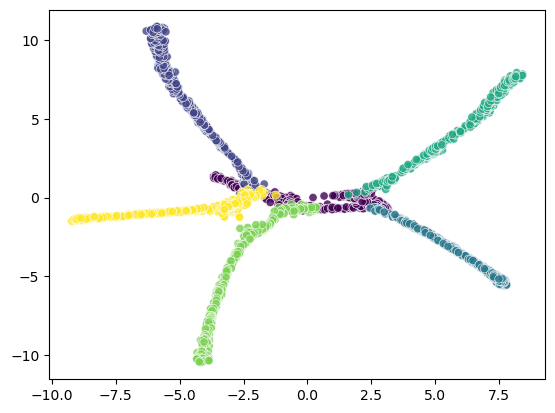

In [10]:
start_time = time.time()
embedding = DTNE()
Y = embedding.fit_transform(tree_X)
end_time = time.time()
print('The code runs {:.0f}s.'.format(end_time - start_time))

sns.scatterplot(x=Y[:,0], y=Y[:,1], hue=labels, palette="viridis", alpha=0.8)
plt.legend().remove()

In [11]:
corr = correlation(tree_geodesic_dist,embedding.dists)
corr[2:]

([0.9121659878788282, (0.9108190359848873, 0.913512939772769)],
 [0.9182306791395567, (0.9170235928159891, 0.9194377654631243)])

In [12]:
tti = manifold.trustworthiness(embedding.dists,tree_X,n_neighbors=100)
tti

0.9930211768146459

In [13]:
np.savetxt("tree_Y_dtne.csv",Y,delimiter=',')